In [135]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
plt.style.use('seaborn-deep')


In [167]:
# Loads the signal and background files into Pandas databases
# highsigmct is used for cut and count analysis as the mct wasn't available for machine learning, but was for cut and count
highsig = (up.open('tmva/last/sig.root'))[b'EwkOneLeptonTwoBjets2018__ntuple;4']
highsig = pd.DataFrame(data=highsig.arrays())

highbck = (up.open('tmva/last/bck.root'))[b'ntuple;4']
highbck = pd.DataFrame(data=highbck.arrays())

highsigmct = up.open('tmva/high/sig.root')[b'EwkOneLeptonTwoBjets2018__ntuple;4']
highsigmct = pd.DataFrame(data=highsigmct.arrays())

lowbck = (up.open('tmva/original/bkg.root'))[b'ntuple;4']
lowbck = pd.DataFrame(data=lowbck.arrays())

lowsig = (up.open('tmva/original/sig.root'))[b'EwkOneLeptonTwoBjets2018__ntuple;4']
lowsig = pd.DataFrame(data=lowsig.arrays())


In [168]:
# Function to find the centre of the bins (given the edges) to plot bar charts
def centre(edges):
    a = np.array([])
    for i in range(len(edges)-1):
         a = np.append(a, ((edges[i]+edges[i+1])/2))
    return a


In [260]:
# Function to find the significance between two cutting points
# cuts on four variables - met, mct, mt and mbb
# Calculates the number of signal and bckground events, aswell as significance
def significance(background, signal, variable, start, stop, error=0, dnn=False, bdt=False):
    'Calculates significance of a variable between two cutting points'
    # y values are the frequency between the bin edges
    # x values are bin edges - array is one value longer than y value

    if dnn == True:
        bins = np.linspace(0, 1, 201)
        firstcut, secondcut = int(start*200), int(stop*200)
    elif bdt == True:
        bins = np.linspace(-1, 1, 201)
        firstcut, secondcut = int((start*100)+100), int((stop*100)+100)
    else:
        bins = np.linspace(0, 1200, 241)
        firstcut, secondcut = int(start/5), int(stop/5)

    bcky, bckx = np.histogram(background[variable], bins=bins, weights=background[b'eventWeight']*background[b'HFScale']*150)
    sigy, sigx = np.histogram(signal[variable], bins=bins, weights=signal[b'eventWeight']*signal[b'HFScale']*150)
    
    bckymc, bckxmc = np.histogram(background[variable], bins=bins)
    sigymc, sigxmc = np.histogram(signal[variable], bins=bins)
    
    numberofsig = sum(sigy[firstcut:secondcut])
    numberofbck = sum(bcky[firstcut:secondcut])
    deltab = sum((bcky[firstcut:secondcut])*error)
    
    numberofmcsig = sum(sigymc[firstcut:secondcut])
    numberofmcbck = sum(bckymc[firstcut:secondcut])
    
    # Significance calulated with error
    significance = numberofsig/(np.sqrt(numberofbck+(deltab**2)))
    print('The significance of a cut including events between {} and {} GeV is {}'.format(start, stop, significance))
    print('The number of signal events is {}'.format(numberofsig))
    print('The number of background events is {}'.format(numberofbck))
    print('The number of MC signal events is {}'.format(numberofmcsig))
    print('The number of MC background events is {}'.format(numberofmcbck))




In [227]:
# Function to plot signal and background of a particular variable before cuttings
def plotter(background, signal, variable, norm=False, dnn=False, bdt=False, mass=False):
    'Plots 1 variable of signal and background before cuttings. Can be normalised or not'
    if dnn == True:
        label = 'Classification'
    elif bdt == True:
        label = 'Classification'
    elif mass == True:
        label = 'Mass (GeV)'
    else:
        label = 'Energy (GeV)'
    plt.hist(background[variable], bins=200, weights=background[b'eventWeight']*background[b'HFScale']*150, histtype='step', label='Background', density=norm)
    plt.hist(signal[variable], bins=200, weights=signal[b'eventWeight']*signal[b'HFScale']*150, histtype='step', label='Signal', density=norm)
    plt.title('{} before cuttings'.format(variable))
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [171]:
# Function to plot signal and background of a variable after cuttings have been made
def plottercut(background, signal, variable, start, stop, dnn=False, bdt=False):
    'Plots background and signal of a variable with a cut'
    # y values are the frequency between the bin edges
    # x values are bin edges - array is one value longer than y value
    # first cut and secondcut are the indexes of y values to cut at - no bin edges needed
    # These are calculated by dividing by 5, as bins are in intervals of 5 if bins 0-1200
    if dnn == True:
        bins = np.linspace(0, 1, 201)
        firstcut, secondcut = int(start*200), int(stop*200)
        label = 'Classification'
    elif bdt == True:
        bins = np.linspace(-1, 1, 201)
        firstcut, secondcut = int(start*200), int(stop*200)
        label = 'Classification'
    else:
        bins = np.linspace(0, 1200, 241)
        firstcut, secondcut = int(start/5), int(stop/5)
        label = 'Energy (GeV)'

    bcky, bckx = np.histogram(background[variable], bins=bins, weights=background[b'eventWeight']*background[b'HFScale']*150)
    sigy, sigx = np.histogram(signal[variable], bins=bins, weights=signal[b'eventWeight']*signal[b'HFScale']*150)


    plt.plot(centre(bckx[firstcut:secondcut+1]), bcky[firstcut:secondcut], label='Background')
    plt.plot(centre(sigx[firstcut:secondcut+1]), sigy[firstcut:secondcut], label='Signal')
    plt.legend()
    plt.xlabel(label)
    plt.ylabel('{}'.format(variable))
    plt.title('{} between {} and {}'.format(variable, start, stop))
    plt.show()


In [182]:
# Was used previously but maxsigml is better
def maxsig(background, signal, variable, error, dnn=False, bdt=False, highmass=False):
    'Function to find how the significance varies with cuttings'
    if dnn == True:
        bins = np.linspace(0, 1, 201)
    elif bdt == True:
        bins = np.linspace(-1, 1, 201)
    else:
        bins = np.linspace(0, 1200, 241)
    if highmass == True:
        threshold = 2
    else:
        threshold = 10

    bcky, bckx = np.histogram(background[variable], bins=bins, weights=background[b'eventWeight']*background[b'HFScale']*150)
    sigy, sigx = np.histogram(signal[variable], bins=bins, weights=signal[b'eventWeight']*signal[b'HFScale']*150)

    

    a= np.array([])
    for i in range(len(bcky)):
        if (sum(sigy[i:])) > 0 and sum(bcky[i:]) > 0:
            numberofsig = sum(sigy[i:])
            numberofbck = sum(bcky[i:])
            deltab = sum((bcky[i:])*error)
    
            # Significance calulated with error
            sig = numberofsig/(np.sqrt(numberofbck+(deltab**2)))
            a = np.append(a, sig)
            
    for i in range(len(bckx)):
        if sum(sigy[i:])<threshold:
            print('Fewer than {} signal events at a cutting made at {}'.format(threshold, centre(bckx[i-1:i+1])))
            break

    plt.plot(centre(bckx)[:len(a)], a)
    plt.plot(np.full(100, centre(bckx[i-1:i+1])), np.linspace(0, np.amax(a), 100))
    plt.xlabel('Energy of cutting (GeV)')
    plt.ylabel('Significance')
    plt.title('Significance of cuttings for {}'.format(variable))
    plt.show()

    return


In [235]:
# Calculates the significance obtained by making different cuts on a particular variable
# The threshold where number of signal is considered low (after rescaling) is 10 for low mass and 5 for high mass
# Plots the significance at different cuttings aswell as where signal events (after rescaling) go below threshold
# Also shows where number of MC signal or background events is below 10
def maxsigml(background, signal, variable, error, dnn=False, bdt=False, highmass=False):
    if dnn == True:
        bins = np.linspace(0, 1, 201)
        label='Cutting threshold (classification)'
    elif bdt == True:
        bins = np.linspace(-1, 1, 201)
        label= 'Cutting threshold (classification)'
    else:
        bins = np.linspace(0, 1200, 241)
        label = 'Cutting threshold (GeV)'
    if highmass == True:
        threshold = 5
    else:
        threshold =10
        
        
    bcky, bckx = np.histogram(background[variable], bins=bins, weights=background[b'eventWeight']*background[b'HFScale']*150)
    sigy, sigx = np.histogram(signal[variable], bins=bins, weights=signal[b'eventWeight']*signal[b'HFScale']*150)
    
    bckymc, bckxmc = np.histogram(background[variable], bins=bins)
    sigymc, sigxmc = np.histogram(signal[variable], bins=bins)

    a= np.array([])
    for i in range(len(bcky)):
        if (sum(sigy[i:])) > 0 and sum(bcky[i:]) > 0:
            numberofsig = sum(sigy[i:])
            numberofbck = sum(bcky[i:])
            deltab = sum((bcky[i:])*error)
    
            # Significance calulated with error
            sig = numberofsig/(np.sqrt(numberofbck+(deltab**2)))
            a = np.append(a, sig)
    
    
    for i in range(len(bckx)):    
        if sum(sigy[i:]) < threshold:
            plt.plot(np.full(100, bckx[i]), np.linspace(0, np.amax(a), 100), label=('Rescaled Sig {} events'.format(threshold)))
            break
                
            
    for i in range(len(bckxmc)):
        if (sum(sigy[i:])) > 0 and sum(bcky[i:]) > 0:
            numberofsigmc = sum(sigymc[i:])
            numberofbckmc = sum(bckymc[i:])
            if numberofsigmc <10 :
                sig10x = i
                plt.plot(np.full(100, bckx[sig10x]), np.linspace(0, np.amax(a), 100), label='Sig 10 events MC')
                break

                
    for i in range(len(bckxmc)):
        if (sum(sigy[i:])) > 0 and sum(bcky[i:]) > 0:
            numberofbckmc = sum(bckymc[i:])
            if numberofbckmc <10:
                bck10x = i
                plt.plot(np.full(100, bckx[bck10x]), np.linspace(0, np.amax(a), 100), label='Bkgd 10 events MC')
                break
    
    plt.plot(centre(bckx)[:len(a)], a)
    plt.xlabel(label)
    plt.ylabel('Significance')
    plt.title('Significance of cuttings for {}'.format(variable))
    plt.legend()
    plt.show()
                
        

In [174]:
# Function which calculates the significance after cuts on mbb, met, mct and mt are made
# Also plots the met of the remaining events after cuts
# Also notifies if the number of MC signal or background events is below 10
# Also shows the number of signal and background events present after rescaling
def triplecut(background, signal, metcut, mtcut, mctcut, mbbmin, mbbmax):
    'Function to cut background and signal on 4 variables - met, mt, mct and mbb'
    bcondition, scondition = np.array([]), np.array([])

    for i in range(len(background[b'met'])):
        if background[b'met'][i]>metcut and background[b'mt'][i]>mtcut and background[b'mct'][i]>mctcut and background[b'mbb'][i]>mbbmin and background[b'mbb'][i]<mbbmax:
            bcondition= np.append(bcondition, i)
    if len(bcondition)<10:
        print('Fewer than 10 background events in MC sample')
    
    for i in range(len(signal[b'met'])):
        if signal[b'met'][i]>metcut and signal[b'mt'][i]>mtcut and signal[b'mct'][i]>mctcut and signal[b'mbb'][i]>mbbmin and signal[b'mbb'][i]<mbbmax:
            scondition = np.append(scondition, i)
    if len(scondition)<10:
        print('Fewer than 10 signal events in MC sample')
    
    bcondition = bcondition.astype(int)
    scondition = scondition.astype(int)

    plt.hist(background[b'met'][bcondition], bins=241, weights=150*background[b'eventWeight'][bcondition]*background[b'HFScale'][bcondition], histtype='step', label='Background')
    plt.hist(signal[b'met'][scondition], bins=241, weights=150*signal[b'eventWeight'][scondition]*signal[b'HFScale'][scondition], histtype='step', label='Signal')
    plt.legend()
    plt.title('MET>{}, MT>{}, MCT>{}'.format(metcut, mtcut, mctcut))
    plt.xlabel('Energy (GeV)')
    plt.ylabel('MET')
    plt.show()

    by_val, bedge_val = np.histogram(background[b'mt'][bcondition], bins=241, weights=150*background[b'eventWeight'][bcondition]*background[b'HFScale'][bcondition])
    sy_val, sedge_val = np.histogram(signal[b'mt'][scondition], bins=241, weights=150*signal[b'eventWeight'][scondition]*signal[b'HFScale'][scondition])

    print('Signal events = {}'.format(sum(sy_val)))
    print('Background events = {}'.format(sum(by_val)))
    print('Significance = {}'.format(sum(sy_val)/np.sqrt(sum(by_val))))
    print('Significance S/sqrt(B+(0.3B)^2) {}'.format(sum(sy_val)/np.sqrt(sum(by_val)+(0.3*sum(by_val))**2)))
            


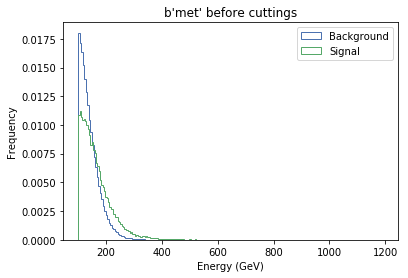

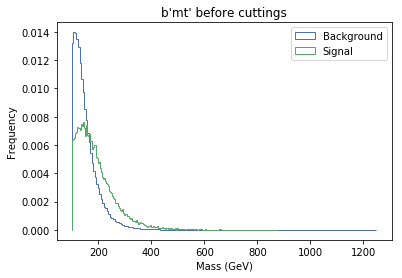

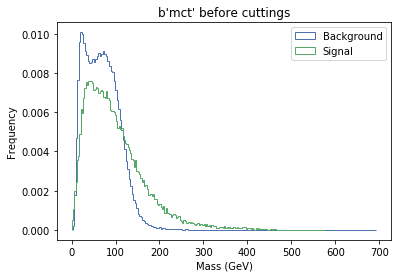

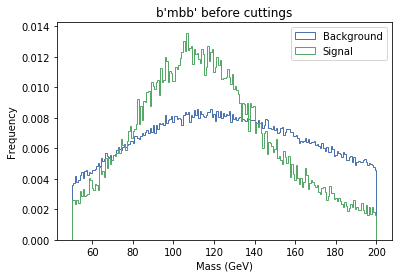

The significance of a cut including events between 0 and 1200 GeV is 0.001671359075768604
The number of signal events is 157.3151092529297
The number of background events is 313741.3125


In [230]:
# Showing the 3 main variables plotted of the low mass before any cuttings, with both curves normalised
# Also shows the significance before any cuttings are made
plotter(lowbck, lowsig, b'met', True)
plotter(lowbck, lowsig, b'mt', True, mass=True)
plotter(lowbck, lowsig, b'mct', True, mass=True)
plotter(lowbck, lowsig, b'mbb', True, mass=True)
significance(lowbck, lowsig, b'met', 0, 1200, 0.3)


In [295]:
'''
 Cutting at different energies will result in a different amount of signal and background
 events, which will have a different significance. Here, cuttings made are iterated over
 (in intervals of 5 GeV), to try and determine where the greatest significance can be found.
 A cutting is defined as including events of energies greater than that specified. For example,
 a cutting at 200 GeV includes all events with an energy greater than 200 GeV.
 The iteration through the cuttings stops when the number of signal OR background events reaches 0. 
 An error of 30% is used here, which
 can easily be changed to another value or 0.
'''


'\n Cutting at different energies will result in a different amount of signal and background\n events, which will have a different significance. Here, cuttings made are iterated over\n (in intervals of 5 GeV), to try and determine where the greatest significance can be found.\n A cutting is defined as including events of energies greater than that specified. For example,\n a cutting at 200 GeV includes all events with an energy greater than 200 GeV.\n The iteration through the cuttings stops when the number of signal OR background events reaches 0. \n An error of 30% is used here, which\n can easily be changed to another value or 0.\n'

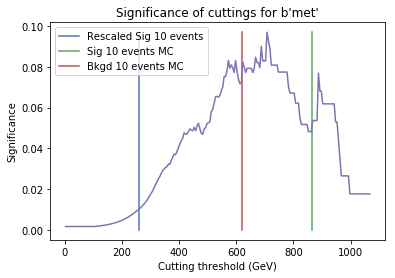

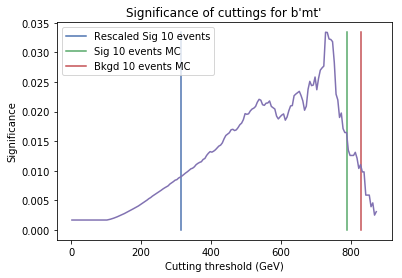

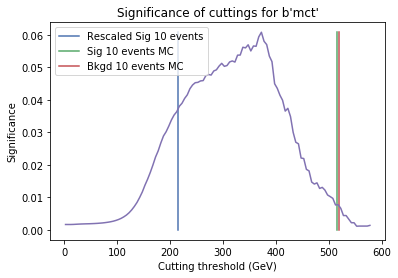

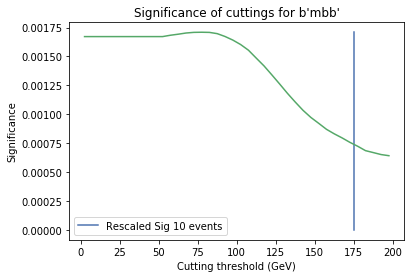

In [224]:
# Calculates the significance of making different cuts on mbb, met, mt and mct for the low mass sample
maxsigml(lowbck, lowsig, b'met', 0.3)
maxsigml(lowbck, lowsig, b'mt', 0.3)
maxsigml(lowbck, lowsig, b'mct', 0.3)
maxsigml(lowbck, lowsig, b'mbb', 0.3)


In [12]:

'''
From these results, it can be seen that good cutting values to start at would be:
MET: 210 GeV
MT: 280 GeV
MCT: 200 GeV

Plots of the 3 variables with these cuttings are shown in the cell below
'''


'\nFrom these results, it can be seen that good cutting values to start at would be:\nMET: 210 GeV\nMT: 280 GeV\nMCT: 200 GeV\n\nPlots of the 3 variables with these cuttings are shown in the cell below\n'

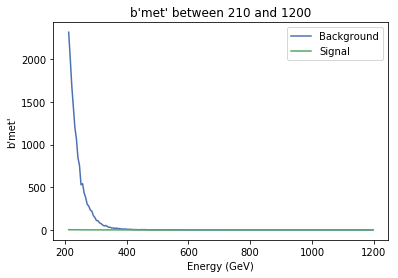

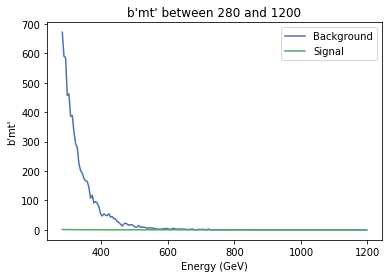

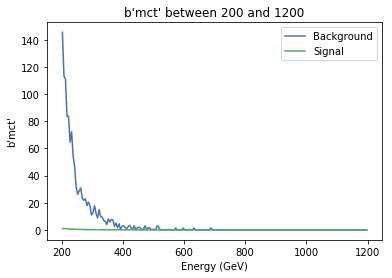

In [296]:
plottercut(lowbck, lowsig, b'met', 210, 1200)
plottercut(lowbck, lowsig, b'mt', 280, 1200)
plottercut(lowbck, lowsig, b'mct', 200, 1200)


In [14]:

'''
Here, MET, MT and MCT are shown with their respective cuttings. These graphs are not normalised,
which is why the background is significantly smaller. However, lets see what significance we can
actually get from applying these three cuts simultaneously to the data. This is shown in the cell
below
'''


'\nHere, MET, MT and MCT are shown with their respective cuttings. These graphs are not normalised,\nwhich is why the background is significantly smaller. However, lets see what significance we can\nactually get from applying these three cuts simultaneously to the data. This is shown in the cell\nbelow\n'

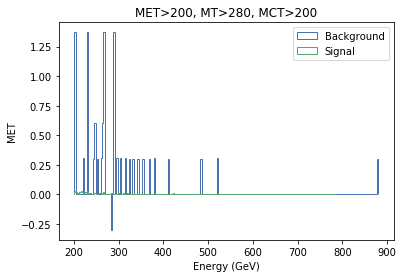

Signal events = 0.46330170962028205
Background events = 11.841470390558243
Significance = 0.13463596457091667
Significance S/sqrt(B+(0.3B)^2) 0.09367507776247572


In [297]:
# Cutting on the low mass at met>200GeV, mt>280GeV, mct>200GeV, 50<mbb<200GeV
triplecut(lowbck, lowsig, 200, 280, 200, 50, 200)


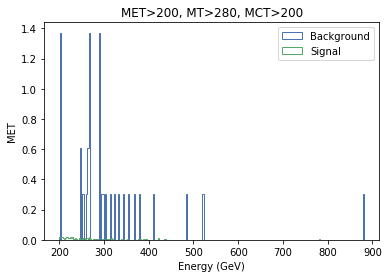

Signal events = 0.4071120952721685
Background events = 10.167130529880524
Significance = 0.1276776280190501
Significance S/sqrt(B+(0.3B)^2) 0.0922625986757447


In [298]:
# Cutting on the low mass at met>200GeV, mt>280GeV, mct>200GeV, 70<mbb<170GeV
triplecut(lowbck, lowsig, 200, 280, 200, 70, 170)

In [17]:
'''Excuse the slight negative value on the graph, I think this is due to a negative value
in the HFScale value from memory. Clearly, applying the 3 cuts simultaneously results in a 
low significance still, but now with less than 1 signal event present. We could try
cutting at lower values to increase the number of signal events, but this would
make the significance smaller still. Let's see how the machine learning does. In the
cell below are how well the machines classified events as being signal or background.
For the DNN, 0 is background, and 1 is signal. For the BDT, -1 is background and 1 is signal.
The classification is effectively how 'certain' the machine is that an event is signal or
background. 
'''


"Excuse the slight negative value on the graph, I think this is due to a negative value\nin the HFScale value from memory. Clearly, applying the 3 cuts simultaneously results in a \nlow significance still, but now with less than 1 signal event present. We could try\ncutting at lower values to increase the number of signal events, but this would\nmake the significance smaller still. Let's see how the machine learning does. In the\ncell below are how well the machines classified events as being signal or background.\nFor the DNN, 0 is background, and 1 is signal. For the BDT, -1 is background and 1 is signal.\nThe classification is effectively how 'certain' the machine is that an event is signal or\nbackground. \n"

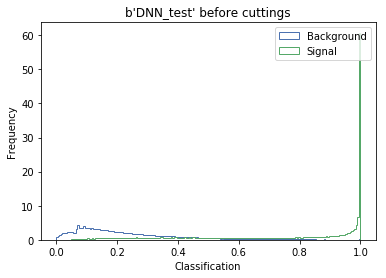

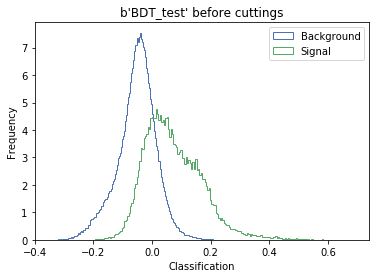

In [188]:
# Plotting the classification of low mass signal and background according to the DNN and BDT
# Both curves are normalised to give an integral of 1
plotter(lowbck, lowsig, b'DNN_test', True, True)
plotter(lowbck, lowsig, b'BDT_test', True, False, True)


In [19]:
'''
The two curves are normalised to show the proportion of events classified correctly regardless
of how many events there actually are. The DNN correctly classifies the vast majority of
events correctly, particularly classifying a high proportion of signal events well. 
The BDT struggles to classify correctly as well, however the mean of the background curve
is less than 0, and the mean of the signal curve is more than 0, which indicates it has classified
better than 50/50 guessing.

First I shall show the two graphs without being normalised - so you can see the actual number of events
'''


'\nThe two curves are normalised to show the proportion of events classified correctly regardless\nof how many events there actually are. The DNN correctly classifies the vast majority of\nevents correctly, particularly classifying a high proportion of signal events well. \nThe BDT struggles to classify correctly as well, however the mean of the background curve\nis less than 0, and the mean of the signal curve is more than 0, which indicates it has classified\nbetter than 50/50 guessing.\n\nFirst I shall show the two graphs without being normalised - so you can see the actual number of events\n'

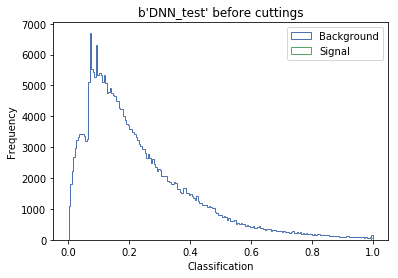

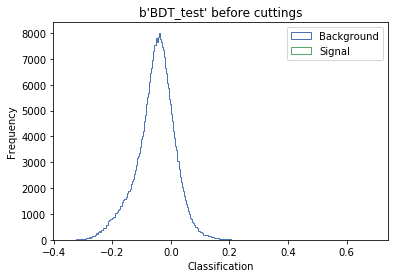

In [189]:
# Showing the classification of the low mass signal and background - this time with no normalisation
plotter(lowbck, lowsig, b'DNN_test', False, False, True)
plotter(lowbck, lowsig, b'BDT_test', False, False, True)


In [299]:
'''
As you can see, the number of background events dwarfs the signal events, 
but let's see if the significance we can get is better than traditional cuttings.
I have chosen an error of 0 to calculate the significance here, as opposed to
30% as with the traditional techniques. This however can be changed if required.


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-299-12dd3c3c1828>, line 5)

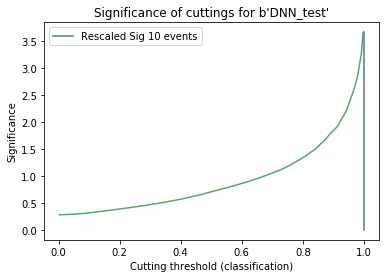

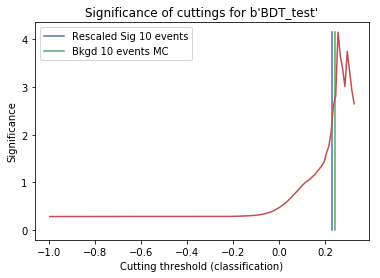

In [246]:
# Significance levels reached with different cuttings - 0% error
maxsigml(lowbck, lowsig, b'DNN_test', 0, True, False)
maxsigml(lowbck, lowsig, b'BDT_test', 0, False, True)

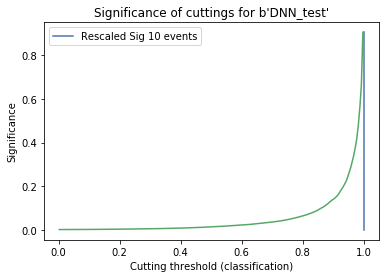

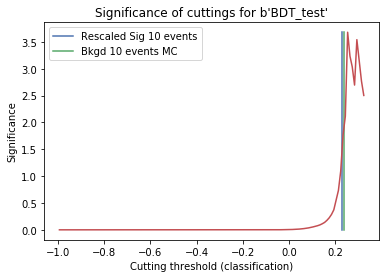

In [250]:
# Significance levels reached with different cuttings - 30% error
maxsigml(lowbck, lowsig, b'DNN_test', 0.3, True, False)
maxsigml(lowbck, lowsig, b'BDT_test', 0.3, False, True)


In [261]:
# Maximum significance reached for the DNN - between 0.995 and 1 classification
significance(lowbck, lowsig, b'DNN_test', 0.995, 1, 0.3, dnn=True)

The significance of a cut including events between 0.995 and 1 GeV is 0.905983332252061
The number of signal events is 47.665733337402344
The number of background events is 169.90625
The number of MC signal events is 12746
The number of MC background events is 172


In [288]:
# Maximum significance reached for the BDT - between 0.235 and 1 classification
significance(lowbck, lowsig, b'BDT_test', 0.235, 1, 0.3, bdt=True)

The significance of a cut including events between 0.235 and 1 GeV is 1.7660798823425166
The number of signal events is 9.4495849609375
The number of background events is 13.125
The number of MC signal events is 2534
The number of MC background events is 15


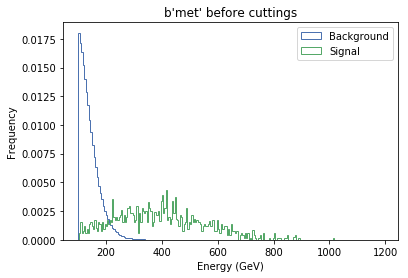

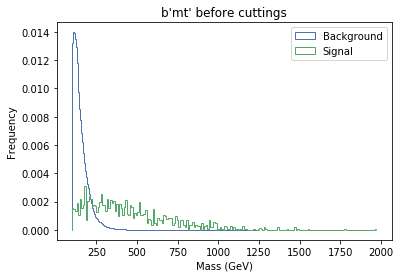

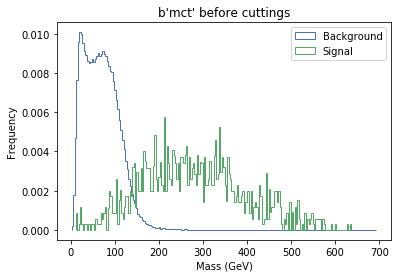

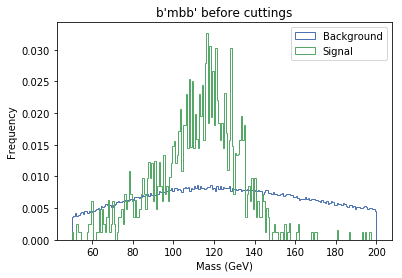

The significance of a cut including events between 0 and 1200 GeV is 0.00015722880423412383
The number of signal events is 14.799014092423022
The number of background events is 313741.3125


In [231]:
# Plots of the met, mbb, mt and mct of the high mass sample
plotter(highbck, highsigmct, b'met', True)
plotter(highbck, highsigmct, b'mt', True, mass=True)
plotter(highbck, highsigmct, b'mct', True, mass=True)
plotter(highbck, highsigmct, b'mbb', True, mass=True)
significance(highbck, highsigmct, b'met', 0, 1200, 0.3)


In [27]:
'''
Here we can see the distribution of the signal is centred at much higher energies
than previously, thus we should be able to differentiate better using traditional
analysis methods. First, lets iterate through some cuttings on each of the
3 variables to see what we get. Note that the initial significance is 0.000157, 
and that there are only 14 signal events!
'''


'\nHere we can see the distribution of the signal is centred at much higher energies\nthan previously, thus we should be able to differentiate better using traditional\nanalysis methods. First, lets iterate through some cuttings on each of the\n3 variables to see what we get. Note that the initial significance is 0.000157, \nand that there are only 14 signal events!\n'

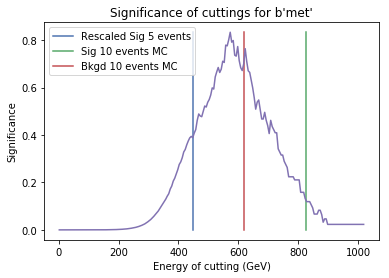

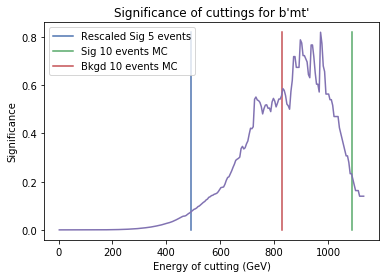

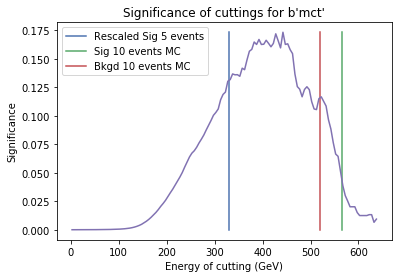

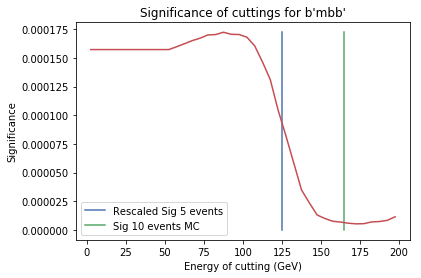

In [213]:
# Finding the significance of different cuttings for the high mass sample
maxsigml(highbck, highsigmct, b'met', 0.3, highmass=True)
maxsigml(highbck, highsigmct, b'mt', 0.3, highmass=True)
maxsigml(highbck, highsigmct, b'mct', 0.3, highmass=True)
maxsigml(highbck, highsigmct, b'mbb', 0.3, highmass=True)



Fewer than 10 background events in MC sample


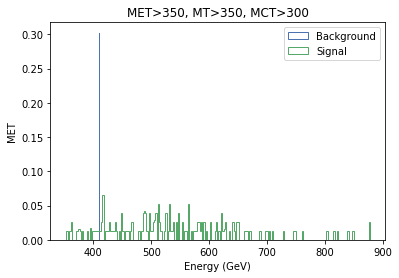

Signal events = 2.191131635569036
Background events = 0.3023672103881836
Significance = 3.9847503977952803
Significance S/sqrt(B+(0.3B)^2) 3.9316138726690633


In [216]:
# Cutting on met, mct, mt and mbb simultaneously. Although significance is high, fewer than 10 MC bck events
triplecut(highbck, highsigmct, 350, 350, 300, 100, 140)

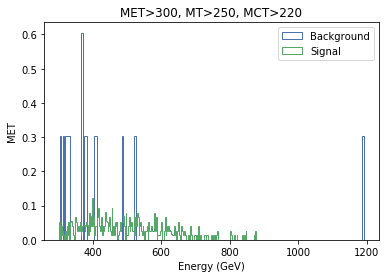

Signal events = 5.850851574912667
Background events = 4.538136571645737
Significance = 2.746504407309045
Significance S/sqrt(B+(0.3B)^2) 2.3142608761662804


In [217]:
# As above, but the number of MC events is not below 10, so this is a statistically significant result
triplecut(highbck, highsigmct, 300, 250, 220, 50, 200)


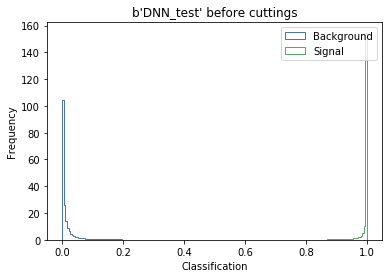

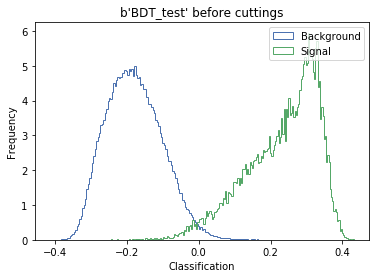

In [218]:
# Plotting the classification from the DNN and BDT on the high mass sample
plotter(highbck, highsig, b'DNN_test', True, True, False)
plotter(highbck, highsig, b'BDT_test', True, False, True)


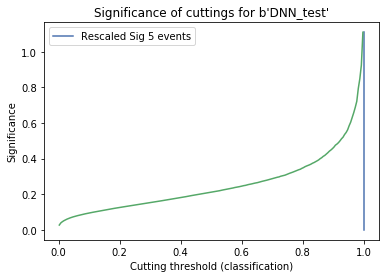

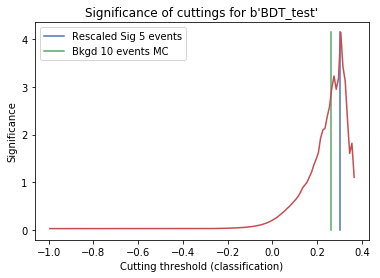

In [245]:
# Significance levels reached of different cuttings with 0% error
maxsigml(highbck, highsig, b'DNN_test', 0, True, False, highmass=True)
maxsigml(highbck, highsig, b'BDT_test', 0, False, True, highmass=True)



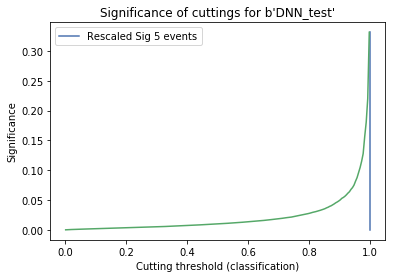

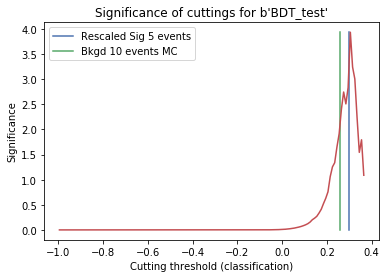

In [243]:
# Significance levels reached of different cuttings with 30% error
maxsigml(highbck, highsig, b'DNN_test', 0.3, True, False, highmass=True)
maxsigml(highbck, highsig, b'BDT_test', 0.3, False, True, highmass=True)


In [264]:
# Highest significance reached for the DNN on the high mass
significance(highbck, highsig, b'DNN_test', 0.995, 1, 0.3, True)

The significance of a cut including events between 0.995 and 1 GeV is 0.33133880652662256
The number of signal events is 11.808987617492676
The number of background events is 113.375
The number of MC signal events is 17751
The number of MC background events is 188


In [294]:
# Highest significance reached for the BDT on the high mass
significance(highbck, highsig, b'BDT_test', 0.3, 1, 0.3, True)

The significance of a cut including events between 0.3 and 1 GeV is 3.9335850741218987
The number of signal events is 4.638670921325684
The number of background events is 1.25
The number of MC signal events is 6985
The number of MC background events is 4
